In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal

from IPython.display import clear_output
from google.colab.patches import cv2_imshow # For showing because cv2.imshow doesn't work normally

In [2]:
# Based on:
# https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/criminisi_cvpr2003.pdf

In [5]:
class InpaintAlgorithm():
    def __init__(self, image, mask, window_size=9, video=None, curr_frame=0):
        assert image.shape[:2] == mask.shape, 'Image and mask must have same shape in 0 and 1 dimensions (HWC)'

        # Original inputs (keeping just in case)
        ######################
        self.original_image = image.astype(np.float32)
        # Image is read in as BGR format, may change to RGB later
        (threshold, self.original_mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        # Mask is binary [0, 255] with 255 inside target, 0 outside
        ######################

        # Values to be updated (not updated when computing priorities but must be updated after)
        ######################
        # Note that self.image and self.mask can be updated

        self.image = np.copy(self.original_image)
        # Image is read in as BGR format, may change to RGB later
        self.mask = np.copy(self.original_mask)

        self.labeled_mask = np.copy(self.mask) # Change later
        self.labeled_mask[self.labeled_mask == 255] = 1 # Change later
        self.labeled_mask = self.labeled_mask.astype(np.float32) # To guarantee negative numbers are allowed

        self.video = np.copy(video)
        self.curr_frame = curr_frame

        # Mask is binary [0, 255] with 255 inside target, 0 outside
        # 1 at edges, 0 otherwise
        self.fill_front = cv2.Canny(self.mask, 0, 255) / 255
        # 0 inside target, 1 outside target
        self.inv_mask = 1 - (np.copy(self.mask) / 255)
        self.C = np.copy(self.inv_mask)  # 0 inside target, 1 outside target
        ######################

        # Constant Scalars
        ######################
        self.num_frames = 1 # Change later
        self.window_size = window_size
        # Enforce must be odd and positive
        assert self.window_size % 2 != 0 and self.window_size > 0, 'Window size must be odd and positive'
        # Default size in paper is 9 "but in practice require the user to set it to be slightly larger than the largest texture element"
        self.alpha = 255
        # self.window_area = np.square(self.window_size)
        self.window_k = (self.window_size - 1) // 2  # Half of the window
        self.image_height, self.image_width = self.mask.shape
        ######################

        # Constant Kernels
        ######################
        self.sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        self.sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        # For calculating normal of target edge
        self.simple_grad_kernel_x = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
        # For calculating normal of target edge
        self.simple_grad_kernel_y = np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]])
        # Used for quick confidences calculation
        self.ones_window = np.ones((self.window_size, self.window_size))
        self.normalization_array = signal.convolve2d(np.ones_like(self.mask), self.ones_window, mode='same', boundary='fill', fillvalue=0)  # Used for quick confidences calculation
        ######################

        # Arrays calculated using the above variables in the various function
        ######################
        self.grad_y = None  # Defined in compute_gradients()
        self.grad_x = None  # Defined in compute_gradients()
        self.edge_normal_y = None  # Defined in compute_normals()
        self.edge_normal_x = None  # Defined in compute_normals()
        self.data = None  # Defined in compute_data()
        self.priorities = None  # Defined in compute_priorities()
        self.subimage_source_regions = None # List of subimage source regions (idx corresponds to frame idx)
        ######################

    # Priority calculation functions
    #################
    def compute_gradients(self):
        # If using lab, have to change this
        grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.grad_y = ndimage.convolve(grayscale_image, self.sobel_y)
        self.grad_x = ndimage.convolve(grayscale_image, self.sobel_x)

    def compute_normals(self):
        edge_grad_x = ndimage.convolve(self.inv_mask, self.simple_grad_kernel_x)
        edge_grad_y = ndimage.convolve(self.inv_mask, self.simple_grad_kernel_y)
        self.edge_normal_y = -1 * edge_grad_x
        self.edge_normal_x = edge_grad_y
        normal_magnitude = np.sqrt(np.square(self.edge_normal_y) + np.square(self.edge_normal_x))
        # Prevent divide by 0 by not normalizing these elements
        normal_magnitude[normal_magnitude == 0] = 1
        self.edge_normal_y /= normal_magnitude
        self.edge_normal_x /= normal_magnitude

    def compute_data(self):
        self.compute_gradients()
        self.compute_normals()
        data = (self.grad_y * self.edge_normal_y) + (self.grad_x * self.edge_normal_x)
        data = np.abs(data)
        data[data == 0] = 1e-7
        # data *= self.fill_front # self.fill_front is assumed to be 1 at edges, 0 else
        data /= self.alpha
        self.data = data

    def compute_confidences(self):
        unnormalized_confidences = signal.convolve2d(self.C, self.ones_window, mode='same', boundary='fill', fillvalue=0)
        confidences = unnormalized_confidences / self.normalization_array
        # confidences *= self.fill_front # self.fill_front is assumed to be 1 at edges, 0 else
        self.C = confidences

    def compute_priorities(self):
        self.compute_data()
        self.compute_confidences()
        # self.fill_front is assumed to be 1 at edges, 0 else
        self.priorities = self.C * self.data * self.fill_front
    #################

    # Filling target patch functions
    #################
    def get_highest_priority_point(self):
        # Return point corresponding to highest priority

        """ Return coordinates for pixel with highest priority value """
        return np.unravel_index(self.priorities.argmax(), self.priorities.shape)

    def get_target_patch(self, p):
        # Return target patch and relevant information such as in-patch masks and coordinates for patch shape

        y, x = p
        if y - self.window_k < 0:
            y_start_diff = self.window_k - y  # Positive, get y_start = y - y_start_diff
        else:
            y_start_diff = self.window_k
        if x - self.window_k < 0:
            x_start_diff = self.window_k - x  # Positive, x_start = x - x_start_diff
        else:
            x_start_diff = self.window_k
        if y + self.window_k + 1 > self.image_height:
            # Positive, y_end = y + y_end_diff
            y_end_diff = self.image_height - (y + 1)
        else:
            y_end_diff = self.window_k + 1
        if x + self.window_k + 1 > self.image_width:
            # Positive, x_end = x + x_end_diff
            x_end_diff = self.image_height - (x + 1)
        else:
            x_end_diff = self.window_k + 1

        # y_start, y_end = max(0, y - self.window_k), min(self.image_height, y + self.window_k + 1) # row top, row bottom
        # x_start, x_end = max(0, x - self.window_k), min(self.image_width, x + self.window_k + 1) # col left, col right
        y_start = y - y_start_diff
        x_start = x - x_start_diff
        y_end = y + y_end_diff
        x_end = x + x_end_diff

        rel_coords = (y_start_diff, y_end_diff, x_start_diff, x_end_diff)

        target_patch = np.copy(self.image[y_start:y_end, x_start:x_end])

        patch_mask = np.copy(self.mask[y_start:y_end, x_start:x_end])
        patch_mask[patch_mask == 255] = 1
        patch_mask = 1 - patch_mask  # Patch mask is 1 in source, 0 in target

        return target_patch, rel_coords, patch_mask

    def get_person_idx(self, target_p):
        # Finding person_idx to use
        person_idx = np.zeros_like(self.mask).astype(np.float32)
        person_idx[target_p] = 1
        person_idx *= self.labeled_mask
        person_idx = np.unique(person_idx)
        person_idx = person_idx[np.where(person_idx != 0)]

        person_idx = person_idx[0].astype(int)
        person_idx -= 1 # Convert to 0-indexing instead of 1-indexing

        return person_idx

    def define_subimage_sources(self):
        # Idea is to provide a set of y, x coordinates to traverse

        # Increase size of labeled mask so that fill front is overlapped by it
        for label in range(1, np.max(self.labeled_mask).astype(int) + 1):
            label_y, label_x = np.where(self.labeled_mask == label)
            self.labeled_mask[max(0, label_y.min() - 1):min(self.image_height - 1, label_y.max() + 1), \
                         max(0, label_y.min() - 1):min(self.image_width - 1, label_x.max() + 1)] = label

        # Creating test image
        labeled_mask = np.copy(self.labeled_mask)

        subimage_source_regions = [] # Each idx has coordinates for label idx + 1
            # Coordinates are of form [(y_coords_1, x_coords_1), (y_coords_2, x_coords_2), ...]

        # Defining subimage source region
        for label in range(1, np.max(labeled_mask).astype(int) + 1):

            # Get height and width of detection
            label_y, label_x = np.where(labeled_mask == label)
            box_height = label_y.max() - label_y.min() + 1
            box_width = label_x.max() - label_x.min() + 1
            
            subimage = labeled_mask[max(0, label_y.min() - box_height):min(labeled_mask.shape[0] - 1, label_y.max() + box_height), 
                                    max(0, label_x.min() - box_width):min(labeled_mask.shape[1] - 1, label_x.max() + box_width)]
            
            subimage[subimage != label] = -label
            
            subimage_source_regions.append(np.where(labeled_mask == -label))

        self.subimage_source_regions = subimage_source_regions

        return

    def find_optimal_source(self, target_patch, person_idx, rel_coords, patch_mask):
        # Returns exemplar from source region

        source_mask = np.copy(self.mask).astype(np.float32)

        source_mask[source_mask == 255] = 1
        source_fill = np.copy(source_mask).astype(np.float32)
        source_mask = 1 - source_mask
        # This stacking is probably inefficient and could be replaced
        source_mask = np.stack([source_mask] * 3, axis=2)
        # source_mask is 0 in target region, 1 in source region
        # Use 500 to indicate if it is in target region or not, just an arbitrary number outside of BGR range
        source_fill[source_fill == 1] = 500
        source_fill = np.stack([source_fill] * 3, axis=2)
        # source_fill is 500 in target region, 0 in source_region
        source_image = (np.copy(self.image) * source_mask) + source_fill

        patch_mask_3d = np.stack([patch_mask] * 3, axis=2)

        min_score = best_patch_variance = np.inf
        optimal_source_patch = None

        y_start_diff, y_end_diff, x_start_diff, x_end_diff = rel_coords

        curr_y_source_coords, curr_x_source_coords = self.subimage_source_regions[person_idx]

        '''
        for y in range(y_start_diff, self.image_height - y_end_diff):
            for x in range(x_start_diff, self.image_width - x_end_diff):
                y_start = y - y_start_diff
                x_start = x - x_start_diff
                y_end = y + y_end_diff
                x_end = x + x_end_diff
        '''
        curr_y_source_coords < y_start_diff
        coord_idxs_to_remove = np.logical_or.reduce((curr_y_source_coords < y_start_diff, curr_x_source_coords < x_start_diff, curr_y_source_coords > self.image_height - 1, curr_x_source_coords > self.image_width - 1))
        coord_idxs_to_keep = np.logical_not(coord_idxs_to_remove) # Possibly just immediately calculate this value later
        curr_y_source_coords[coord_idxs_to_keep]
        curr_x_source_coords[coord_idxs_to_keep]
        
        best_i = 0 

        for coord_idx in range(len(curr_y_source_coords)):
            y = curr_y_source_coords[coord_idx]
            x = curr_x_source_coords[coord_idx]

            y_start = max(0, y - y_start_diff)
            x_start = max(0, x - x_start_diff)
            y_end = min(self.image_height - 1, y + y_end_diff)
            x_end = min(self.image_width - 1, x + x_end_diff)

            curr_source_patch = source_image[y_start:y_end, x_start:x_end, :]
            if 500 in curr_source_patch:  # Invalid patch; not entirely bound in source region
                continue
            

            if self.video is None:
                curr_score = np.sum(np.square(curr_source_patch - target_patch) * patch_mask_3d)

                patch_mean = np.zeros(3)
                patch_mask = np.array(patch_mask, dtype=np.bool)

                B = curr_source_patch[:,:,0]
                patch_mean[0] = np.mean(B[patch_mask])
                
                G = curr_source_patch[:,:,1]
                patch_mean[1] = np.mean(G[patch_mask])
            
                R = curr_source_patch[:,:,2]
                patch_mean[2] = np.mean(R[patch_mask])

                inv_patch_mask = np.invert(patch_mask)
                w_mean, w_var = 1, 1
                if curr_score <= min_score:
                    patch_var = 0 
                    patch_var += np.sum(np.square(B[inv_patch_mask] - patch_mean[0]))
                    patch_var += np.sum(np.square(G[inv_patch_mask] - patch_mean[1]))
                    patch_var += np.sum(np.square(R[inv_patch_mask] - patch_mean[2])) 

                    if curr_score < w_mean * min_score or patch_var < w_var * best_patch_variance:
                        best_patch_variance = patch_var
                        min_score = curr_score
                        optimal_source_patch = curr_source_patch
            else:
                frame_window = 3 // 2
                start_frame = self.curr_frame - frame_window
                end_frame = self.curr_frame + frame_window + 1
                
                if start_frame < 0:
                    diff = abs(start_frame)
                    start_frame = 0
                    end_frame += diff

                video_len = len(self.video)
                if end_frame > video_len:
                    diff = end_frame - video_len
                    start_frame -= diff
                    end_frame = video_len
                
                source_patches = self.video[start_frame:end_frame, y_start:y_end, x_start:x_end]
                source_patches[frame_window] = curr_source_patch

                for i, source_patch in enumerate(source_patches):
                    curr_score = np.sum(np.square(source_patch - target_patch) * patch_mask_3d)

                    patch_mean = np.zeros(3)
                    patch_mask = np.array(patch_mask, dtype=np.bool)

                    B = source_patch[:,:,0]
                    patch_mean[0] = np.mean(B[patch_mask])
                    
                    G = source_patch[:,:,1]
                    patch_mean[1] = np.mean(G[patch_mask])
                
                    R = source_patch[:,:,2]
                    patch_mean[2] = np.mean(R[patch_mask])

                    inv_patch_mask = np.invert(patch_mask)
                    w_mean, w_var = 1, 1
                    if curr_score <= min_score:
                        patch_var = 0 
                        patch_var += np.sum(np.square(B[inv_patch_mask] - patch_mean[0]))
                        patch_var += np.sum(np.square(G[inv_patch_mask] - patch_mean[1]))
                        patch_var += np.sum(np.square(R[inv_patch_mask] - patch_mean[2])) 

                        if curr_score < w_mean * min_score or patch_var < w_var * best_patch_variance:
                            best_patch_variance = patch_var
                            min_score = curr_score
                            optimal_source_patch = source_patch
                            best_i = i
        
        assert optimal_source_patch is not None, "Source region not found."
        print("Optimal Source Patch from Frame: ", self.curr_frame + best_i)
        return optimal_source_patch

    def update_image_arrays(self, optimal_source_patch, target_p, rel_coords, patch_mask):
        # Update all image arrays

        y, x = target_p

        y_start_diff, y_end_diff, x_start_diff, x_end_diff = rel_coords
        y_start = y - y_start_diff
        x_start = x - x_start_diff
        y_end = y + y_end_diff
        x_end = x + x_end_diff

        # Updating image
        # patch_mask is 0 in target, 1 in source
        # Make target area in image 0
        # Make source area in patch 0
        image_patch_mask = np.stack([patch_mask] * 3, axis=2)
        self.image[y_start:y_end, x_start:x_end, :] = \
            (self.image[y_start:y_end, x_start:x_end, :] * image_patch_mask) + \
            (optimal_source_patch * (1 - image_patch_mask))

        # Updating mask and related arrays
        # Update patch to be source
        # mask is 1 at edges, 0 otherwise
        # inv_mask is 0 inside target, 1 outside target
        self.mask[y_start:y_end, x_start:x_end] = 0
        self.fill_front = cv2.Canny(self.mask, 0, 255) / 255
        self.inv_mask = 1 - (np.copy(self.mask) / 255)

        # Updating C
        # Only update in target region
        C_origin = self.C[y, x] * np.ones_like(patch_mask)
        self.C[y_start:y_end, x_start:x_end] = \
            (self.C[y_start:y_end, x_start:x_end] * patch_mask) + \
            (C_origin * (1 - patch_mask))

    def update_image(self):
        # Use priorities to update image

        target_p = self.get_highest_priority_point()
        target_patch, rel_coords, patch_mask = self.get_target_patch(target_p)
        person_idx = self.get_person_idx(target_p)
        optimal_source_patch = self.find_optimal_source(target_patch, person_idx, rel_coords, patch_mask)
        self.update_image_arrays(optimal_source_patch, target_p, rel_coords, patch_mask)

    def _do_inpainting_single(self):
        # Perform one iteration of inpainting

        self.compute_priorities()
        self.update_image()

    def do_inpainting(self):
        # Perform all iterations of inpainting

        self.define_subimage_sources()
        while np.sum(self.fill_front) > 0:
            self._do_inpainting_single()
            curr_image = self.image.astype(np.uint8)
            
            # clear_output(wait=False)
        return self.image
    #################


In [3]:
test_image = cv2.imread('steve2_resized.png', cv2.IMREAD_COLOR)
test_mask = cv2.imread('steve2_resized_mask.png', cv2.IMREAD_GRAYSCALE)

In [4]:
test_video = np.stack([test_image]*4)
test_video_mask = np.stack([test_mask]*4)

In [6]:
class InpaintVideo():
    def __init__(self, video, mask, window_size=9):
        """
        video: Video input T x H x W x C
        mask: Video mask input T x H x W
        """
        assert video.shape[:3] == mask.shape
        
        self.window_size = window_size

        self.original_video = video
        self.video = np.copy(self.original_video)

        self.original_mask = mask
        self.mask = np.copy(self.original_mask)

    def inpaint_curr_frame(self, curr_frame):
        inpaintAlgorithm = InpaintAlgorithm(self.video[curr_frame], self.mask[curr_frame], \
                                            self.window_size, self.original_video, curr_frame)
        inpainted_frame = inpaintAlgorithm.do_inpainting()
        return inpainted_frame
    
    def inpaint(self):
        for frame in range(self.video.shape[0]):
            inpainted_frame = self.inpaint_curr_frame(frame)
            print("Frame ", frame)
            cv2_imshow(inpainted_frame)
            self.video[frame] = inpainted_frame

Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Optimal Source Patch from Frame:  0
Frame  0


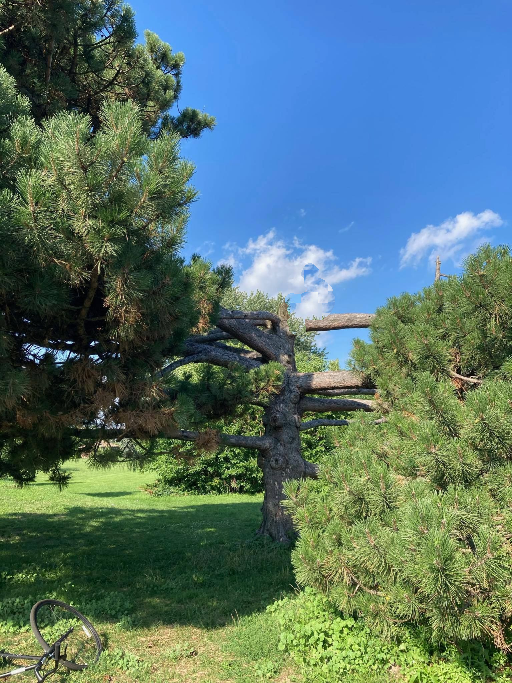

Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Optimal Source Patch from Frame:  1
Frame  1


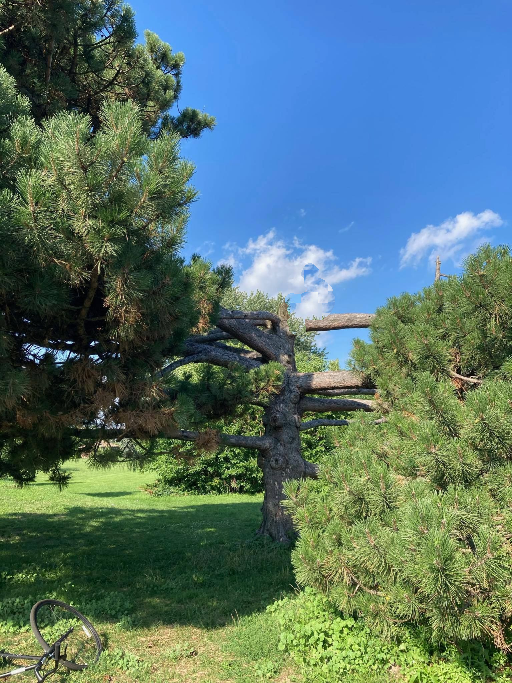

Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Optimal Source Patch from Frame:  2
Frame  2


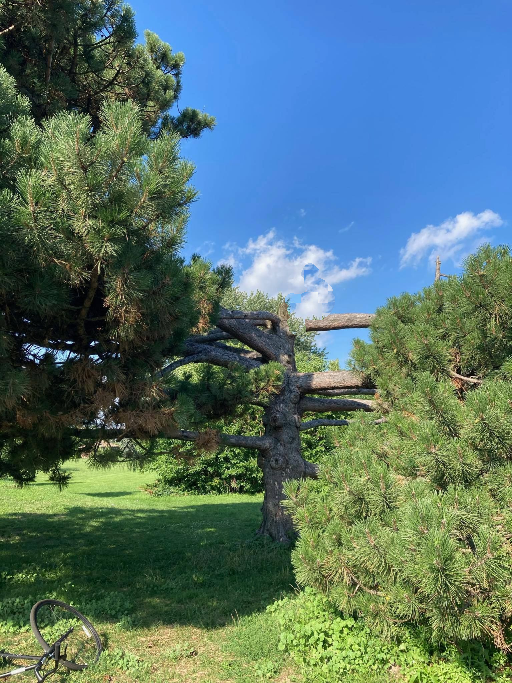

Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Optimal Source Patch from Frame:  3
Frame  3


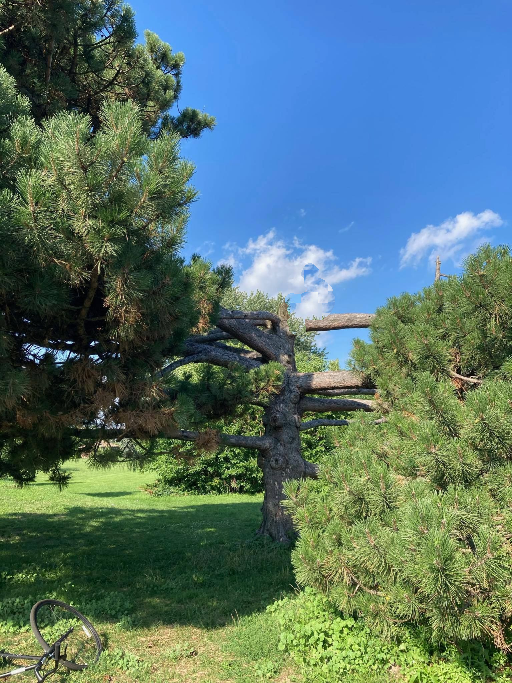

In [7]:
inpaintVideo = InpaintVideo(test_video, test_video_mask, window_size=21)
inpaintVideo.inpaint()

In [ ]:
curr_image = cv2.imread('index.png', cv2.IMREAD_COLOR)
cv2_imshow(cv2.bilateralFilter(curr_image,9,75,75))
cv2_imshow(curr_image)

In [ ]:
# Testing code for subimaging
# Idea is to provide a set of y, x coordinates to traverse

# Creating test image
labeled_mask = np.ones(shape=(4, 2))
labeled_mask = np.pad(labeled_mask, (3, 5))

subimage_masks = [] # Each idx has mask for label idx + 1
    # Contains masks for only a particular person detection
subimage_source_regions = [] # Each idx has coordinates for label idx + 1
    # Coordinates are of form [(y_coords_1, x_coords_1), (y_coords_2, x_coords_2), ...]

# Defining subimage source region
for label in range(1, np.max(labeled_mask).astype(int) + 1):
    curr_mask = np.copy(labeled_mask)
    curr_mask[curr_mask != label] = 0
    curr_mask[curr_mask != 0] = 255

    subimage_masks.append(curr_mask)

    label_y, label_x = np.where(labeled_mask == label)
    box_height = label_y.max() - label_y.min() + 1
    box_width = label_x.max() - label_x.min() + 1
    
    subimage = labeled_mask[max(0, label_y.min() - box_height):min(labeled_mask.shape[0] - 1, label_y.max() + box_height), 
                            max(0, label_x.min() - box_width):min(labeled_mask.shape[1] - 1, label_x.max() + box_width)]
    
    subimage[subimage != label] = -label
    
    subimage_source_regions.append(np.where(labeled_mask == -label))